# Market Data Analysis
This notebook visualizes market data from the `data` folder.

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata

## Load and Combine Data
Load all CSV files from the `data` folder and combine them into a single DataFrame.

In [17]:
data_folder = '../data/marketDataClose25-04'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = []

for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df['Source'] = file  # Add a column to identify the source file
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

## Plot Market Data
Visualize the data from all files.

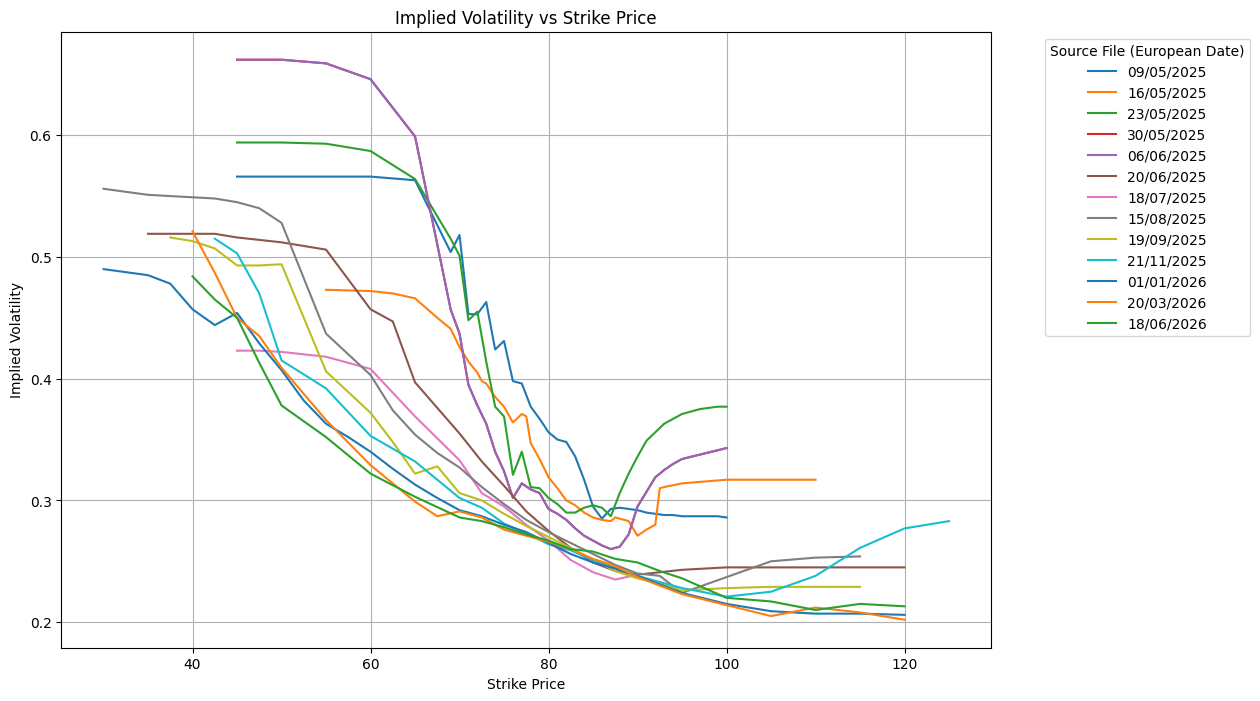

In [18]:
# Convert source filenames to European date format (dd/mm/YYYY)
def convert_to_european_date(filename):
    date_part = filename.split('.')[0]
    month = date_part[:2]
    day = date_part[2:4]
    year = '20' + date_part[4:]
    return f'{day}/{month}/{year}'

# Sort the legend entries by year, month, and day before plotting
legend_entries = []
for source, group in combined_data.groupby('Source'):
    european_date = convert_to_european_date(source)
    year, month, day = map(int, european_date.split('/')[::-1])
    legend_entries.append(((year, month, day), group))

# Sort legend entries by year, month, and day
legend_entries.sort(key=lambda x: x[0])

plt.figure(figsize=(12, 8))

for (_, group) in legend_entries:
    plt.plot(group['Strike'], group['IV_Call'], label=convert_to_european_date(group['Source'].iloc[0]))

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike Price')
plt.legend(title='Source File (European Date)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Plot Mid Prices for Out-of-the-Money Options
Visualize the mid prices for calls above 81.25 and puts below 81.25.

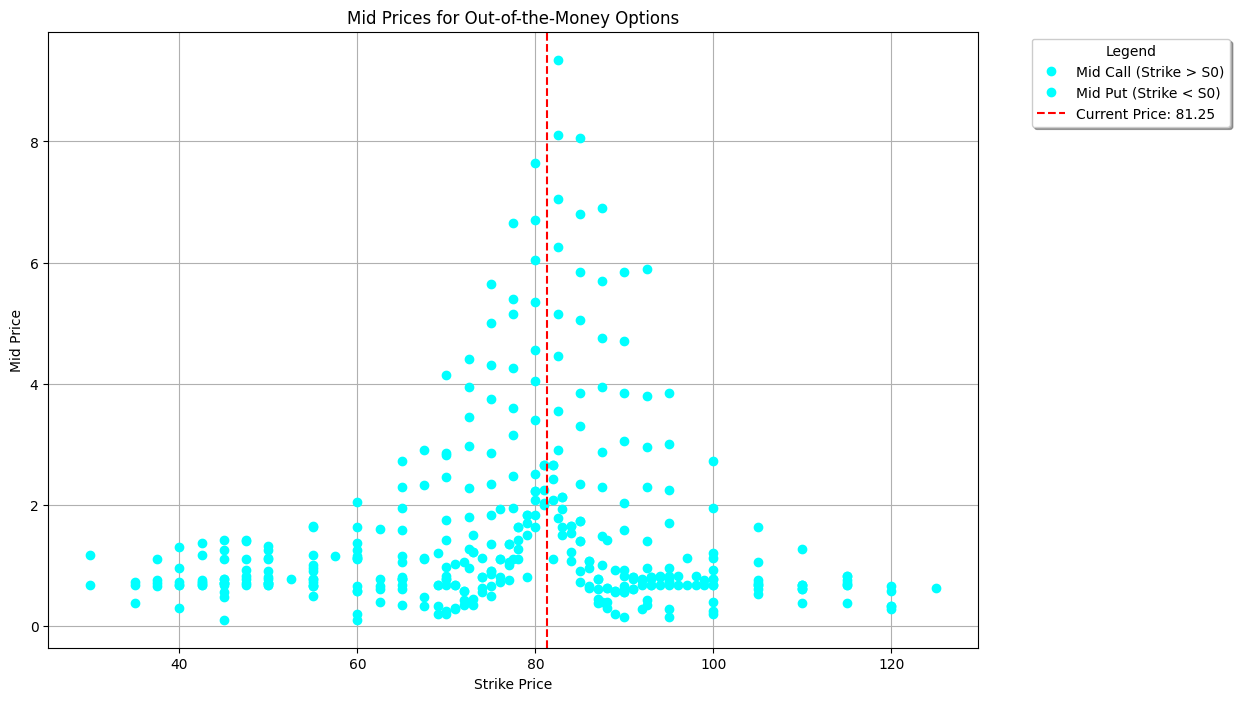

In [19]:
# Filter out-of-the-money options
S0 = 81.25
out_of_money_calls = combined_data.loc[combined_data['Strike'] > S0].copy()
out_of_money_puts = combined_data.loc[combined_data['Strike'] < S0].copy()

# Calculate mid prices for calls and puts
out_of_money_calls['Mid_Call'] = (out_of_money_calls['Bid_Call'] + out_of_money_calls['Ask_Call']) / 2
out_of_money_puts['Mid_Put'] = (out_of_money_puts['Bid_Put'] + out_of_money_puts['Ask_Put']) / 2

# Plot mid prices for calls and puts
plt.figure(figsize=(12, 8))

# Plot mid prices for calls
plt.plot(out_of_money_calls['Strike'], out_of_money_calls['Mid_Call'], 'o', color='cyan', label='Mid Call (Strike > S0)')

# Plot mid prices for puts
plt.plot(out_of_money_puts['Strike'], out_of_money_puts['Mid_Put'], 'o', color='cyan', label='Mid Put (Strike < S0)')

# Display current price on the chart
plt.axvline(x=S0, color='red', linestyle='--', label=f'Current Price: {S0}')

plt.xlabel('Strike Price')
plt.ylabel('Mid Price')
plt.title('Mid Prices for Out-of-the-Money Options')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## 3D Mid Price Surface
Visualize the mid price surface for calls based on strike and maturity.

In [20]:
# Drop rows with NaN in 'Bid_Call' and 'Ask_Call' before interpolation
combined_data_clean = combined_data.dropna(subset=['Bid_Call', 'Ask_Call'])

# Calculate mid prices for calls
combined_data_clean['Mid_Call'] = (combined_data_clean['Bid_Call'] + combined_data_clean['Ask_Call']) / 2

# Extract strike prices (K), maturities (T), and mid prices (Mid_Call)
K_values = combined_data_clean['Strike']
T_values = combined_data_clean['Maturity']
Mid_Call_values = combined_data_clean['Mid_Call']

# Create a grid for the interpolation (100 points along each axis)
K_grid, T_grid = np.meshgrid(np.linspace(min(K_values), max(K_values), 100),
                             np.linspace(min(T_values), max(T_values), 100))

# Stack K and T values into a 2D array (each pair of K, T forms a point)
points = np.vstack((K_values, T_values)).T

# Perform 2D interpolation using griddata
Mid_Call_surface = griddata(points, Mid_Call_values, (K_grid, T_grid), method='cubic')

# Plot the smoothed price surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Check if the surface contains valid data
if np.all(np.isnan(Mid_Call_surface)):
    print("Warning: The interpolation resulted in NaN values.")
else:
    ax.plot_surface(K_grid, T_grid, Mid_Call_surface, cmap='plasma')

    # Add labels
    ax.set_xlabel('Strike Price (K)')
    ax.set_ylabel('Maturity (T)')
    ax.set_zlabel('Mid Price (Call)')

plt.show()

KeyError: 'Maturity'